# Load Required Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest

from interpret.glassbox import ExplainableBoostingRegressor

import plotly.express as px

from IPython.display import Image, display

import session_info

# Import and Prep Data

In [2]:
X, y = fetch_openml('telco-customer-churn', version=1, as_frame=True, return_X_y=True, parser='auto')

total_df = pd.concat([pd.DataFrame(y), X], axis=1)

del(X, y)

total_df = total_df.rename(columns={'gender': 'Gender',
                                    'SeniorCitizen': 'Senior Citizen',
                                    'tenure': 'Tenure',
                                    'PhoneService': 'Phone Service',
                                    'MultipleLines': 'Multiple Lines',
                                    'InternetService': 'Internet Service',
                                    'OnlineSecurity': 'Online Security',
                                    'OnlineBackup': 'Online Backup',
                                    'DeviceProtection': 'Device Protection',
                                    'TechSupport': 'Tech Support',
                                    'StreamingTV': 'Streaming TV',
                                    'StreamingMovies': 'Streaming Movies',
                                    'PaperlessBilling': 'Paperless Billing',
                                    'PaymentMethod': 'Payment Method',
                                    'MonthlyCharges': 'Monthly Charges',
                                    'TotalCharges': 'Total Charges'})

total_df['Senior Citizen'] = np.where(total_df['Senior Citizen'] == 1, 'Yes', 'No')
total_df['Total Charges'] = pd.to_numeric(total_df['Total Charges'], errors='coerce')
total_df['Tenure'] = total_df['Tenure'].astype('int64')

total_df.head()

,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,No,Female,No,Yes,No,1,No,'No phone service',DSL,No,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,No,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,Yes,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,No,Male,No,No,No,45,No,'No phone service',DSL,Yes,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,Yes,Female,No,No,No,2,Yes,No,'Fiber optic',No,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


In [3]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Churn              7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [4]:
# Investiate the 11 records with missing values for  `Total Charges`

total_df['Binary Total Charges'] = np.where(total_df['Total Charges'].isna(), 'Missing', 'Not Missing')

total_df['Binary Tenure'] = total_df['Tenure'].apply(lambda x: '1+' if x > 0 else ('0' if x == 0 else '<0'))

total_df[['Binary Total Charges', 'Binary Tenure', 'Churn']].value_counts()

Binary Total Charges  Binary Tenure  Churn
Not Missing           1+             No       5163
                                     Yes      1869
Missing               0              No         11
Name: count, dtype: int64

In [5]:
# Discard records with missing `Total Charges`
total_df = total_df[~total_df['Total Charges'].isnull()].reset_index(drop=True)
total_df.drop(columns=['Binary Total Charges', 'Binary Tenure'], inplace=True)

# Create a unique identifier for each row
total_df['CustomerID'] = total_df.index + 1
total_df = total_df[ [ 'CustomerID'] + [col for col in total_df.columns if col != 'CustomerID']]

total_df.head()

,CustomerID,Churn,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,No,Female,No,Yes,No,1,No,'No phone service',DSL,...,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,2,No,Male,No,No,No,34,Yes,No,DSL,...,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,3,Yes,Male,No,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,4,No,Male,No,No,No,45,No,'No phone service',DSL,...,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,5,Yes,Female,No,No,No,2,Yes,No,'Fiber optic',...,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


In [6]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7032 non-null   int64  
 1   Churn              7032 non-null   object 
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure             7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract           7032 

# Develop Anomaly Model

---

Note: This dataset was initially released for supervised machine learning to demonstrate how to predict *churn*.  We're going to pretend *churn* isn't in the data and develop an anomaly detection model using Isolation Forest.

---

In [7]:
features = [col for col in total_df.columns if col not in ['CustomerID', 'Churn']]

print(f"Number of Features: {len(features)}")
print(f"\nFeature Names: {features}")

Number of Features: 19

Feature Names: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges']


In [8]:
categorical_features = list(total_df[features].select_dtypes(include='object').columns)

numeric_features = list(total_df[features].select_dtypes(include=['float64', 'int64']).columns)

print(f"Categorical Features: {categorical_features}")
print(f"\nNumeric Features: {numeric_features}")

Categorical Features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

Numeric Features: ['Tenure', 'Monthly Charges', 'Total Charges']


In [9]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [10]:
ohe.fit(total_df[categorical_features]);

In [11]:
X_df = pd.concat([total_df[numeric_features].reset_index(drop=True),
                  pd.DataFrame(ohe.transform(total_df[categorical_features]).toarray(),
                               columns=ohe.get_feature_names_out()).reset_index(drop=True)],
                 axis=1)

X_df

,Tenure,Monthly Charges,Total Charges,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,Streaming Movies_Yes,Contract_'One year',Contract_'Two year',Contract_Month-to-month,Paperless Billing_No,Paperless Billing_Yes,Payment Method_'Bank transfer (automatic)',Payment Method_'Credit card (automatic)',Payment Method_'Electronic check',Payment Method_'Mailed check'
0,1,29.85,29.85,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,45,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,24,84.80,1990.50,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7028,72,103.20,7362.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7029,11,29.60,346.45,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
7030,4,74.40,306.60,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [12]:
ifm = IsolationForest(random_state=123)

ifm.fit(X_df);

In [13]:
ifm_output_df = pd.DataFrame({'predict': ifm.predict(X_df),
                              'score_samples': ifm.score_samples(X_df),
                              'decision_function': ifm.decision_function(X_df)})

ifm_output_df

,predict,score_samples,decision_function
0,-1,-0.569679,-0.069679
1,-1,-0.565452,-0.065452
2,-1,-0.523488,-0.023488
3,-1,-0.600649,-0.100649
4,1,-0.445680,0.054320
...,...,...,...
7027,-1,-0.568791,-0.068791
7028,-1,-0.550659,-0.050659
7029,-1,-0.593358,-0.093358
7030,-1,-0.534422,-0.034422


In [14]:
ifm_output_df.corr()

,predict,score_samples,decision_function
predict,1.000000,0.684757,0.684757
score_samples,0.684757,1.000000,1.000000
decision_function,0.684757,1.000000,1.000000


In [15]:
ifm_output_df.groupby('predict', as_index=True).agg({'predict': ['count'],
                                                     'score_samples': ['min', 'max'],
                                                     'decision_function': ['min', 'max']})

predict score_samples           decision_function          
          count           min       max               min       max
predict                                                            
-1         6052     -0.645176 -0.500032         -0.145176 -0.000032
 1          980     -0.499973 -0.440036          0.000027  0.059964

In [16]:
total_df = pd.concat([total_df.reset_index(drop=True),
                      pd.DataFrame(ifm.predict(X_df), columns=['Predicted Class']), 
                      pd.DataFrame(ifm.decision_function(X_df), columns=['Anomaly Score'])],
                     axis=1)

total_df['Predicted Class'] = np.where(total_df['Predicted Class'] == 1, 'Anomaly', 'Not an Anomaly')

total_df['Anomaly Decile'] = 10 - pd.qcut(total_df['Anomaly Score'], 10, labels=False)

front_vars = ['CustomerID', 'Churn', 'Predicted Class', 'Anomaly Score', 'Anomaly Decile']

total_df = total_df[front_vars + [col for col in total_df.columns if col not in front_vars]]

total_df.head()

,CustomerID,Churn,Predicted Class,Anomaly Score,Anomaly Decile,Gender,Senior Citizen,Partner,Dependents,Tenure,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,No,Not an Anomaly,-0.069679,8,Female,No,Yes,No,1,...,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,2,No,Not an Anomaly,-0.065452,8,Male,No,No,No,34,...,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,3,Yes,Not an Anomaly,-0.023488,3,Male,No,No,No,2,...,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,4,No,Not an Anomaly,-0.100649,10,Male,No,No,No,45,...,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,5,Yes,Anomaly,0.054320,1,Female,No,No,No,2,...,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


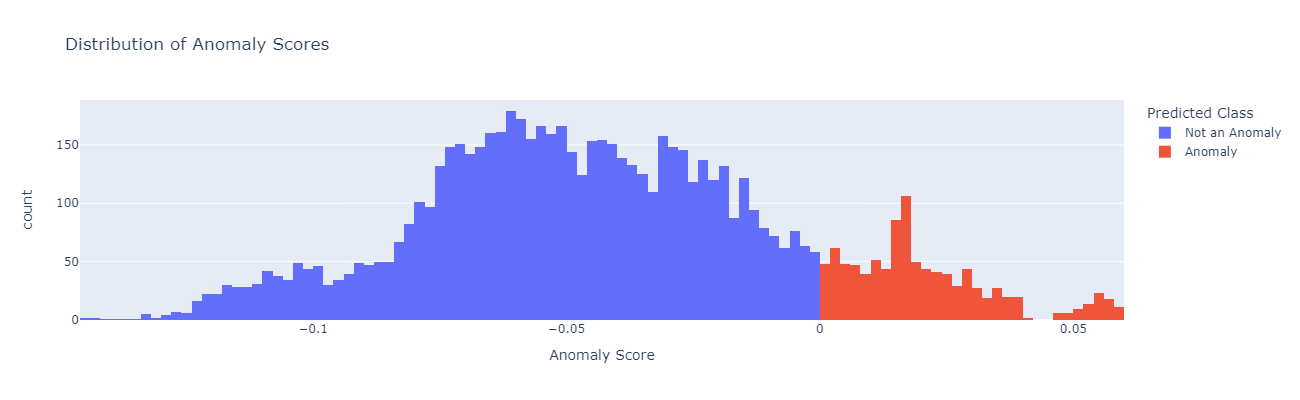

In [17]:
fig = px.histogram(total_df, x='Anomaly Score', color='Predicted Class', nbins=150,
                   title='Distribution of Anomaly Scores')

# To display in JupyterLab
# fig.show()

# To display static image in GitHub and JupyterLab
display(Image(fig.to_image(format='png', width=1300, height=400)))

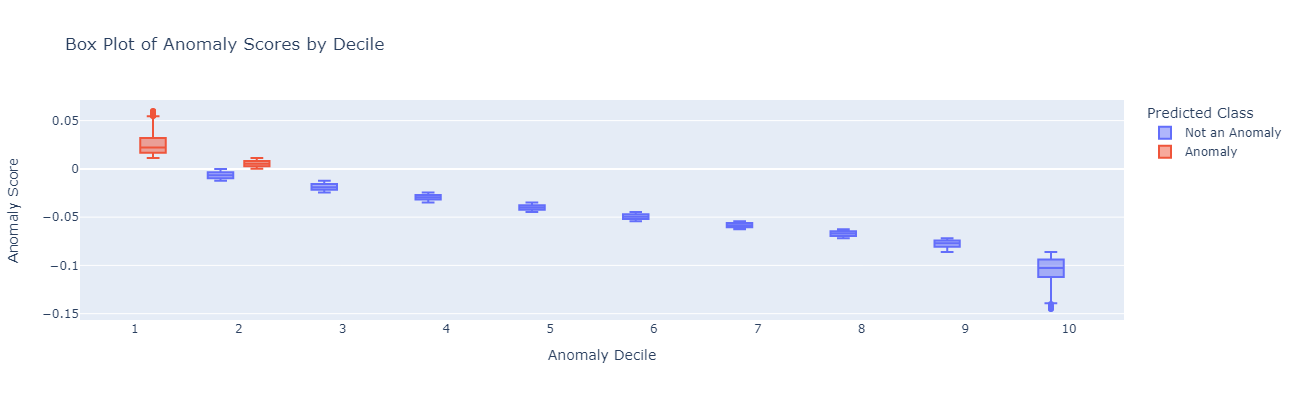

In [18]:
fig = px.box(total_df, x='Anomaly Decile', y='Anomaly Score', color='Predicted Class',
             title='Box Plot of Anomaly Scores by Decile')

fig.update_layout(xaxis={'dtick':1})

# fig.show()

display(Image(fig.to_image(format='png', width=1300, height=400)))

# Develop Surrogate Model for Explainability

In [19]:
y = total_df['Anomaly Score']

X = total_df[features]

ebm = ExplainableBoostingRegressor(random_state=123, interactions=0)

ebm.fit(X, y);

In [20]:
total_scored_df = pd.concat([total_df, 
                             pd.DataFrame(ebm.predict(X), columns=['EBM Score'])],
                            axis=1)

front_vars = front_vars + ['EBM Score']

total_scored_df = total_scored_df[front_vars + [col for col in total_scored_df.columns if col not in front_vars]]

total_scored_df.head()

,CustomerID,Churn,Predicted Class,Anomaly Score,Anomaly Decile,EBM Score,Gender,Senior Citizen,Partner,Dependents,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,1,No,Not an Anomaly,-0.069679,8,-0.053765,Female,No,Yes,No,...,Yes,No,No,No,No,Month-to-month,Yes,'Electronic check',29.85,29.85
1,2,No,Not an Anomaly,-0.065452,8,-0.058339,Male,No,No,No,...,No,Yes,No,No,No,'One year',No,'Mailed check',56.95,1889.50
2,3,Yes,Not an Anomaly,-0.023488,3,-0.024374,Male,No,No,No,...,Yes,No,No,No,No,Month-to-month,Yes,'Mailed check',53.85,108.15
3,4,No,Not an Anomaly,-0.100649,10,-0.116287,Male,No,No,No,...,No,Yes,Yes,No,No,'One year',No,'Bank transfer (automatic)',42.30,1840.75
4,5,Yes,Anomaly,0.054320,1,0.013457,Female,No,No,No,...,No,No,No,No,No,Month-to-month,Yes,'Electronic check',70.70,151.65


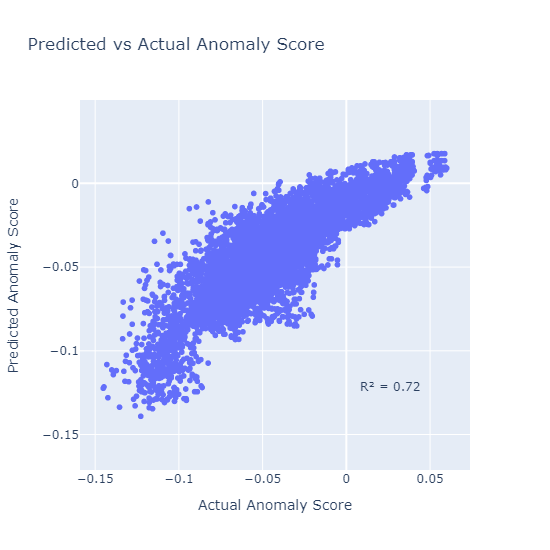

In [21]:
fig = px.scatter(total_scored_df, x='Anomaly Score', y='EBM Score',
                 height=550, width=550,
                 labels={"Anomaly Score": "Actual Anomaly Score", "EBM Score": "Predicted Anomaly Score"},
                 title="Predicted vs Actual Anomaly Score")

fig.update_layout(yaxis={'scaleanchor': 'x', 'scaleratio': 1},
                  hovermode=False)

fig.add_annotation(text=f"R\u00b2 = {ebm.score(X, y):.2f}", x=0.88, y=0.2,
                   xref='paper', yref='paper', showarrow=False)

# fig.show()

display(Image(fig.to_image(format='png')))

---

Note: Since one could argue that the surrogate model is able to *predict* the actual anomaly score *sufficiently well*, we can use EBM's explainability properties to explain the Isolation Forest drivers.

---

# Global Feature Importance

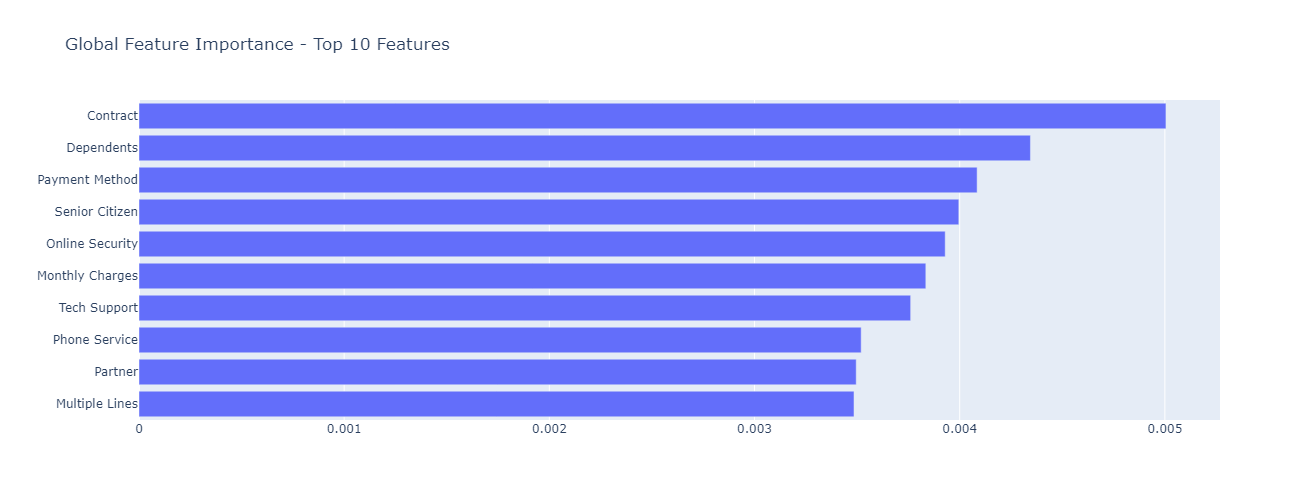

In [22]:
NUM_GLOBAL_FEATURES_TO_SHOW = 10

ebm_global = ebm.explain_global()

global_importance_df  = pd.DataFrame(ebm_global.data()).sort_values(by=['scores'], ascending=False, ignore_index=True)

temp_df = global_importance_df[: NUM_GLOBAL_FEATURES_TO_SHOW]

fig = px.bar(temp_df, x='scores', y='names', orientation='h',
             labels={'names':'', 'scores':''},
             title=f"Global Feature Importance - Top {NUM_GLOBAL_FEATURES_TO_SHOW} Features")

fig.update_layout(yaxis=dict(autorange='reversed'), hovermode=False)

# fig.show()

display(Image(fig.to_image(format='png', width=1300, height=500)))

# Local Explainability Examples

In [23]:
# Derive each feature's explanation score for each record

explanation_scores_df = pd.concat([total_df[['CustomerID']].reset_index(drop=True),
                                   pd.DataFrame(ebm.predict_and_contrib(total_df[features])[1],
                                                columns=ebm.feature_names_in_)],
                                  axis=1)

explanation_scores_df = explanation_scores_df.melt(id_vars='CustomerID', value_name='explanation_score')

explanation_scores_df.sort_values('CustomerID').head(len(features)).sort_values(by='explanation_score',
                                                                                key=lambda x: abs(x),
                                                                                ascending=False).reset_index(drop=True)

,CustomerID,variable,explanation_score
0,1,Phone Service,-0.018199
1,1,Multiple Lines,-0.018019
2,1,Monthly Charges,-0.007854
3,1,Tenure,0.007642
4,1,Total Charges,0.006587
5,1,Payment Method,0.005917
6,1,Internet Service,-0.004737
7,1,Contract,0.004542
8,1,Online Security,0.003951
9,1,Tech Support,0.003809


In [24]:
# Create a data frame with custom formats and labels for explainability

data_values_df = total_df.copy()

data_values_df = data_values_df[['CustomerID'] + features]

data_values_df['Monthly Charges'] = '$' + data_values_df['Monthly Charges'].apply("{:,.2f}".format)
data_values_df['Total Charges'] = '$' + data_values_df['Total Charges'].apply("{:,.2f}".format)
data_values_df['Tenure'] = data_values_df['Tenure'].apply("{:,.0f}".format)

data_values_df = data_values_df.melt(id_vars=['CustomerID'], value_name='data_value')

data_values_df['data_value'] = data_values_df['data_value'].str.replace("'", "")

data_values_df['label'] = data_values_df['variable'].astype(str) + " = " + data_values_df['data_value'].astype(str)

data_values_df[data_values_df['CustomerID'] == 1].reset_index(drop=True)

,CustomerID,variable,data_value,label
0,1,Gender,Female,Gender = Female
1,1,Senior Citizen,No,Senior Citizen = No
2,1,Partner,Yes,Partner = Yes
3,1,Dependents,No,Dependents = No
4,1,Tenure,1,Tenure = 1
5,1,Phone Service,No,Phone Service = No
6,1,Multiple Lines,No phone service,Multiple Lines = No phone service
7,1,Internet Service,DSL,Internet Service = DSL
8,1,Online Security,No,Online Security = No
9,1,Online Backup,Yes,Online Backup = Yes


In [25]:
local_df = pd.merge(total_scored_df[front_vars], data_values_df, on='CustomerID')

local_df = pd.merge(local_df, explanation_scores_df, on=['CustomerID', 'variable'])

local_df['abs_explanation_score'] = abs(local_df['explanation_score'])

local_df.head()

,CustomerID,Churn,Predicted Class,Anomaly Score,Anomaly Decile,EBM Score,variable,data_value,label,explanation_score,abs_explanation_score
0,1,No,Not an Anomaly,-0.069679,8,-0.053765,Gender,Female,Gender = Female,0.000002,0.000002
1,1,No,Not an Anomaly,-0.069679,8,-0.053765,Senior Citizen,No,Senior Citizen = No,0.002385,0.002385
2,1,No,Not an Anomaly,-0.069679,8,-0.053765,Partner,Yes,Partner = Yes,-0.003622,0.003622
3,1,No,Not an Anomaly,-0.069679,8,-0.053765,Dependents,No,Dependents = No,0.003097,0.003097
4,1,No,Not an Anomaly,-0.069679,8,-0.053765,Tenure,1,Tenure = 1,0.007642,0.007642


In [26]:
# Select records with highest and lowest anomaly scores to illustrate explainability

max_score_customer = total_scored_df.sort_values('Anomaly Score', ascending=False).head(1)['CustomerID'].reset_index(drop=True)[0]
min_score_customer = total_scored_df.sort_values('Anomaly Score', ascending=True).head(1)['CustomerID'].reset_index(drop=True)[0]

print(max_score_customer)
print(min_score_customer)

577
104


In [27]:
def explain_single_anomaly_score(customer_id, num_features=999, plot_height=450):
    truth = total_df[total_df['CustomerID'] == customer_id]['Churn'].item()
    
    temp_df = local_df[local_df['CustomerID'] == customer_id].sort_values('abs_explanation_score', ascending=False)
    
    if temp_df.shape[0] <= num_features:
        subtitle = f"All {temp_df.shape[0]:,} features"
    else:
        subtitle = f"Top {num_features} features"
    
    temp_df = temp_df.head(num_features)
    
    temp_df['influence'] = np.where(temp_df['explanation_score'] > 0, 'More Anomalous', 'Less Anomalous')
    
    fig = px.bar(temp_df, x='explanation_score', y='label', color='influence',
                 color_discrete_map={'More Anomalous': 'red', 'Less Anomalous': 'green'},
                 orientation='h', height=plot_height,
                 labels={'label':'', 'explanation_score':'Explanation Score', 'influence':'Influence'},
                 title=f"Local Explanation for CustomerID {customer_id} (actual churn = {truth})<br><sup>{subtitle}</sup>")
    
    fig.update_layout(yaxis=dict(autorange='reversed'),
                      showlegend=True,
                      hovermode=False)
    
    # fig.show()
    
    display(Image(fig.to_image(format='png', width=1300, height=500)))

## Record with Highest Anomaly Score

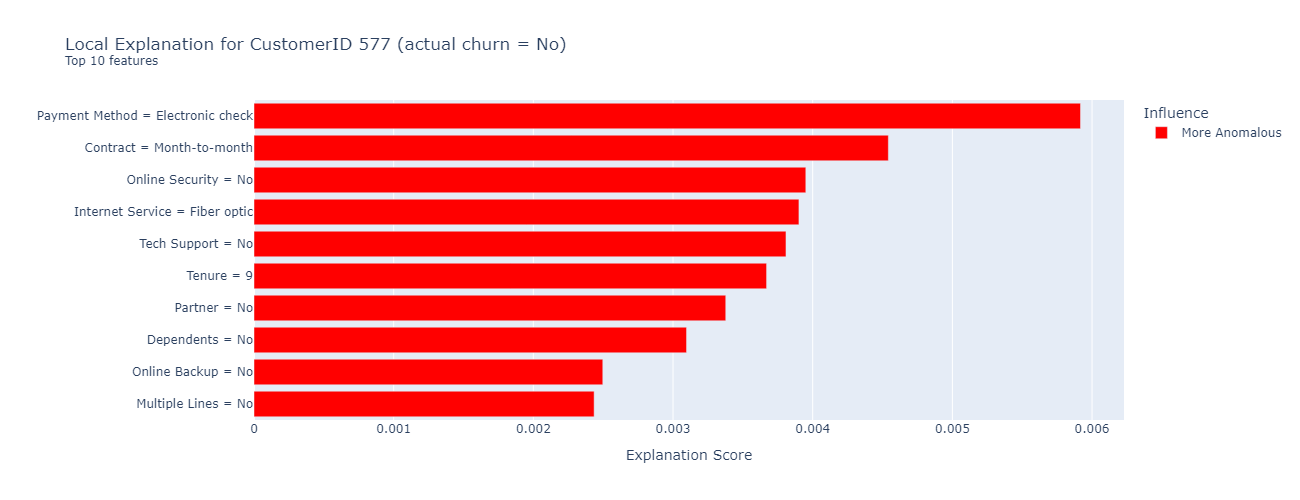

In [28]:
explain_single_anomaly_score(max_score_customer, num_features=10)

## Record with Lowest Anomaly Score

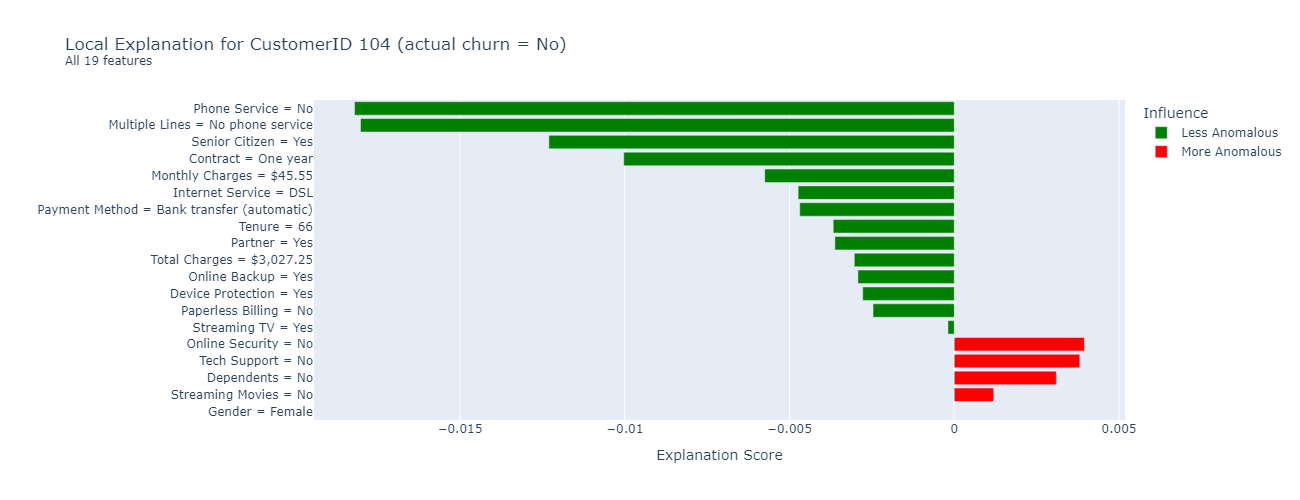

In [29]:
explain_single_anomaly_score(min_score_customer)

# Bonus: Anomaly vs Churn

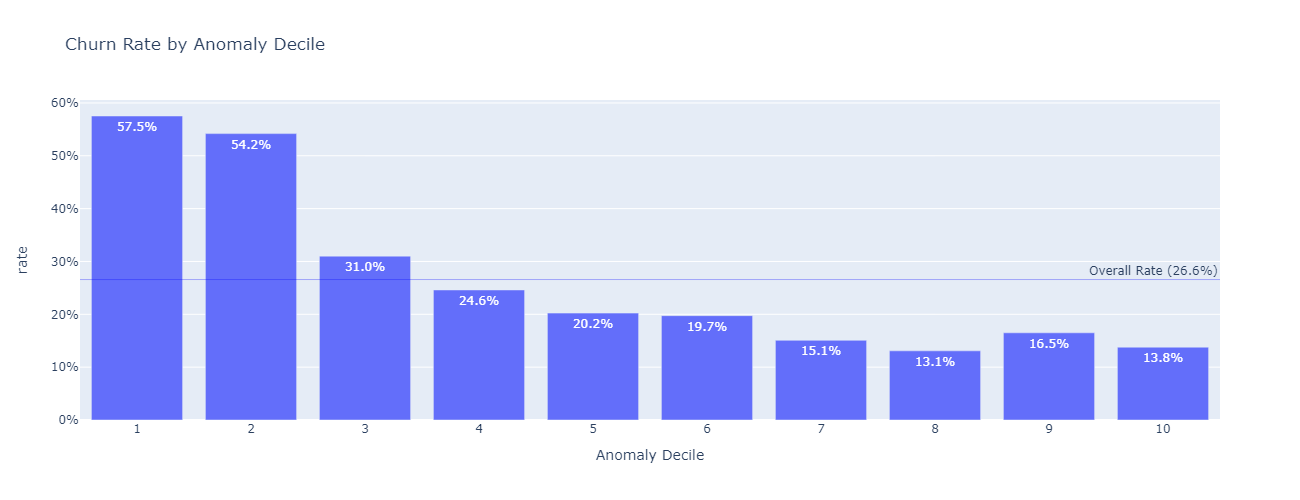

In [30]:
temp_df = total_scored_df[['Churn', 'Anomaly Decile']].copy()

temp_df['Churn'] = temp_df['Churn'] == 'Yes'

rates_by_decile_df = temp_df.groupby('Anomaly Decile').agg(rate = ('Churn', 'mean'))

overall_rate_text = f"Overall Rate ({temp_df['Churn'].mean()*100:.1f}%)"

fig = px.bar(rates_by_decile_df, x=rates_by_decile_df.index, y='rate',
             text_auto='.1%', labels={'rate', 'Actual Churn Rate'},
             title='Churn Rate by Anomaly Decile')

fig.add_hline(temp_df['Churn'].mean(),
              line_color='blue', line_width=1, opacity=0.3,
              annotation_text=overall_rate_text)

fig.layout.yaxis.tickformat = ',.0%'

fig.update_layout(hovermode=False, xaxis={'dtick': 1})

# fig.show()

display(Image(fig.to_image(format='png', width=1300, height=500)))

# Appendix

## Session Info for Reproducibility

In [31]:
session_info.show()